In [2]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

import acquire

# Exercises
- file name: `time_series_anomaly_detection.py` or `time_series_anomaly_detection.ipynb`

The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

**Hint**: You will need to explore the database (yay SQL!)

1. Label students by the program they are in.
1. Is it possible to identify the user_id of a staff member?
1. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.
1. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 
1. Plot the access activity of these students.

**BONUS:** Can you identify users who are viewing both the web dev and data science curriculum?

In [3]:
df = acquire.get_data()

In [17]:
df.head()

,date,time,endpoint,user_id,cohort_id,cohort_name,slack,start_date,end_date,program_id
0,2018-01-26,09:55:03,/,1,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1
1,2018-01-26,09:56:02,java-ii,1,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,Hampton,#hampton,2015-09-22,2016-02-06,1
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2


In [80]:
df[df.endpoint.isna()]

,endpoint,user_id,cohort_id,cohort_name,slack,start_date,end_date,program_id,program,latest_cohort
datetime,,,,,,,,,,
2020-04-08 09:25:18,None,586,55.0,Curie,#curie,2020-02-03,2020-07-07,3,Data Science,Curie


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype          
---  ------       --------------   -----          
 0   date         847330 non-null  datetime64[ns] 
 1   time         847330 non-null  timedelta64[ns]
 2   endpoint     847329 non-null  object         
 3   user_id      847330 non-null  int64          
 4   cohort_id    847330 non-null  float64        
 5   cohort_name  847330 non-null  object         
 6   slack        847330 non-null  object         
 7   start_date   847330 non-null  datetime64[ns] 
 8   end_date     847330 non-null  datetime64[ns] 
 9   program_id   847330 non-null  int64          
dtypes: datetime64[ns](3), float64(1), int64(2), object(3), timedelta64[ns](1)
memory usage: 64.6+ MB


In [19]:
df.date = pd.to_datetime(df.date)
df.start_date = pd.to_datetime(df.start_date)
df.end_date = pd.to_datetime(df.end_date)
df.time = pd.to_timedelta(df.time)
df['datetime'] = df.date + df.time
df = df.set_index('datetime')
df = df.drop(columns=['date','time'])
df.head()

In [71]:
df = df.sort_index()

## Ex begin

1. Label students by the program they are in.


In [69]:
# df.groupby('program_id').cohort_name.value_counts()

Using the alumni page at [https://alumni.codeup.com/](https://alumni.codeup.com/) and referencing it with the value counts above I found:

| program_id | program_name |
| - | - |
| 1 | Full-Stack PHP |
| 2 | Full-Stack Java |
| 3 | Data Science |
| 4 | Front-End |

In [30]:
pnames = {  1: 'Full Stack PHP',
            2: 'Full Stack Java',
            3: 'Data Science',
            4: 'Front-End'
            }

In [33]:
df['program'] = df.program_id.replace(pnames)

1. Is it possible to identify the user_id of a staff member?


In [40]:
df[df.cohort_name == 'Staff'].user_id.nunique()

51

1. Identify students who are accessing our curriculum pages beyond the end of their time at Codeup.


In [50]:
df.groupby('user_id').cohort_name.value_counts()
# [df.groupby('user_id').cohort_name.nunique() > 1]

user_id  cohort_name
1        Staff          5787
         Hampton        1617
2        Teddy          1541
3        Teddy          1562
4        Teddy           692
                        ... 
977      Oberon           86
978      Oberon           55
979      Oberon          127
980      Staff             3
981      Neptune          42
Name: cohort_name, Length: 952, dtype: int64

In [55]:
multi_cohort_users = df.groupby('user_id').cohort_name.nunique()[(df.groupby('user_id').cohort_name.nunique() > 1)].index.tolist()

In [163]:
df[df.user_id.isin(multi_cohort_users)].groupby('user_id').cohort_name.value_counts()

user_id  cohort_name
1        Staff           5787
         Hampton         1617
11       Staff          15178
         Arches          2735
25       Ulysses         1358
                        ...  
707      Bash             277
752      Jupiter          440
         Luna              94
895      Florence         364
         Neptune            6
Name: cohort_name, Length: 80, dtype: int64

for each user id
get latest record's cohort
then apply that value across all earlier records

In [164]:
df['latest_cohort'] = df.user_id.replace(dict(df.groupby('user_id').cohort_name.agg('last')))

In [166]:
df.latest_cohort.value_counts()

Staff         109964
Ceres          40730
Zion           38156
Fortuna        37822
Jupiter        36669
Voyageurs      35636
Apex           33568
Deimos         33245
Ganymede       32711
Darden         32318
Teddy          30475
Betelgeuse     29739
Hyperion       29565
Europa         28466
Ulysses        28099
Wrangell       25586
Bayes          25491
Xanadu         24978
Kalypso        24316
Andromeda      23529
Yosemite       19736
Curie          18109
Luna           17630
Bash           17436
Marco          16397
Easley         14741
Florence        8568
Neptune         7270
Quincy          6903
Sequoia         6204
Kings           2799
Pinnacles       2158
Oberon          1672
Olympic         1405
Lassen          1390
Arches           976
Niagara          795
Mammoth          691
Glacier          578
Joshua           292
Ike              247
Hampton           95
Badlands          93
Franklin          72
Apollo             5
Denali             4
Everglades         1
Name: latest_

In [165]:
df[(df.cohort_name != 'Staff') & (df.index > df.end_date)].user_id.value_counts()

53     8197
495    5125
64     3767
314    3166
11     2735
       ... 
163       1
66        1
952       1
212       1
394       1
Name: user_id, Length: 565, dtype: int64

1. Identify students who present anomalous activity using the Bollinger Band method, but reduce K to 2. 


First calculate the bolinger band

In [95]:
freq = df.iloc[:,1].resample('D').count()

In [109]:
def get_bolinger_band(resampled_s, k=3, span=14):
    """For a given time-indexed series, retun a dataframe defining the bounds of a bolinger band."""
    midband = resampled_s.ewm(span=span).mean()
    stdev = resampled_s.ewm(span=span).std()
    highband = midband + stdev*k
    lowerband = midband - stdev*k
    out = pd.concat([highband, midband, lowerband], axis=1)
    out.columns =['high_band','mid_band','low_band'] 
    return out

In [112]:
bb= get_bolinger_band(freq, k=2)

In [168]:
bb.head()

,high_band,mid_band,low_band
datetime,,,
2018-01-26,NaN,533.000000,NaN
2018-01-27,799.185281,370.678571,-57.828138
2018-01-28,672.510915,293.254669,-86.001578
2018-01-29,1045.435830,443.081581,-159.272668
2018-01-30,1017.093136,487.673935,-41.745266


<AxesSubplot:xlabel='datetime'>

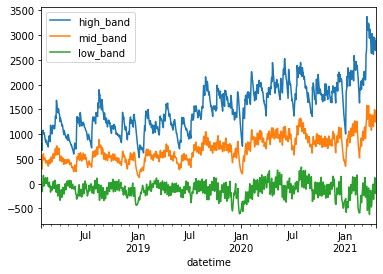

In [116]:
bb.plot()

Then compare the observation to its position in the bolinger band.

In [121]:
# def calc_band_position(resamped_s, band_df):
#     perc_b = (resamped_s - band_df.low_band)/(band_df.high_band - band_df.low_band)
#     return perc_b

In [123]:
def calc_band_position(observation, upper_band, lower_band):
    return (observation - lower_band)/(upper_band - lower_band)

In [127]:
result = calc_band_position(freq, bb.high_band, bb.low_band)
result[(result > 1) | (result < 0)]

Series([], Freq: D, dtype: float64)

Now do it for each student

In [ ]:
students = df[df.cohort_name != 'Staff']
staff = df[df.cohort_name == 'Staff']


In [176]:

def by_user_dict(df):
    by_user = {}
    for user in df.user_id.unique().tolist():
        this = by_user[user] = {}
        this['df'] = df[df.user_id == user]
        this['daily_visits'] = this['df'].iloc[:,1].resample('D').count()
        this['band'] = get_bolinger_band( this['daily_visits'] , k=2, span=14)
        this['band_pos'] = calc_band_position(this['daily_visits'], this['band'].high_band, this['band'].low_band)
        this['band_breached'] = (this['band_pos'] - .5).abs() > 0.5
    return by_user

In [177]:
staff_dict = by_user_dict(staff)
students_dict = by_user_dict(students)

In [160]:
for user, data in staff_dict.items():
    breach_count = data['band_breached'].sum()
    if breach_count > 0:
        print(user, breach_count)
        

In [175]:
for user, data in students_dict.items():
    breach_count = data['band_breached'].sum()
    if breach_count > 0:
        print(user, breach_count)

1 11
2 2
3 5
4 2
5 4
6 5
7 12
8 1
9 2
10 25
11 10
12 12
13 1
14 5
15 5
16 5
17 1
18 22
19 10
20 29
21 5
23 1
25 12
26 12
27 5
28 9
29 6
30 1
31 12
32 2
33 3
34 3
35 3
36 10
37 10
38 7
39 1
40 16
41 27
42 1
43 8
44 3
46 1
47 1
50 14
51 17
52 3
53 26
56 7
57 7
60 7
64 16
65 3
67 11
68 24
69 1
70 2
72 15
75 12
76 5
80 29
83 5
84 5
90 6
91 1
92 3
93 3
94 6
96 12
98 2
99 10
101 3
102 3
105 10
106 8
110 2
112 2
115 1
116 12
118 10
119 5
120 31
121 7
122 8
123 19
124 14
126 16
127 32
128 27
130 5
131 9
133 1
134 4
135 6
136 5
138 6
139 4
140 1
141 2
142 18
143 10
144 1
145 22
146 5
147 4
148 11
149 1
151 2
153 15
154 3
155 16
156 6
157 8
158 5
159 11
160 13
162 7
164 1
167 5
168 9
169 1
170 6
171 13
172 6
173 1
175 13
178 1
179 12
180 3
181 4
182 4
183 9
184 4
185 13
186 44
187 6
188 6
189 27
190 5
191 2
192 5
193 13
194 2
195 8
196 3
197 10
198 6
199 3
200 5
201 22
202 2
203 3
204 7
205 5
206 7
207 3
208 8
88 16
210 3
211 7
214 2
215 4
217 22
218 2
219 10
220 8
221 1
222 3
223 5
224 2
225 9


1. Plot the access activity of these students.

<AxesSubplot:xlabel='datetime'>

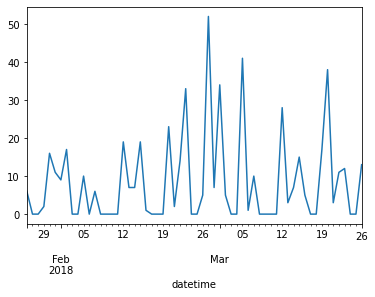

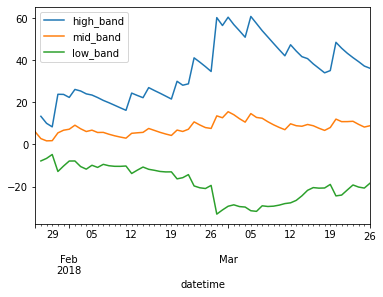

In [167]:
students_dict[34]['daily_visits'].plot()
students_dict[34]['band'].plot()